# The Correlation of Genre with Differences in Ratings

### Group members
Robert Coughlin A12892298  
Chris Doherty A12581585  
Mia Schloss A13366340  



## Research Question
How does the movie’s genre impact the audience score and the critic score, and the difference between the two?
(What is the correlation between the difference in audience and critic scores for movies and the movie’s genre?)

## Background and Prior Work
We are interested in this question because we have noticed that movie critics and audiences frequently seem to rate movies differently. This phenomenon occurs partially because they view movies in different ways: critics focus more on the artistic and social impacts of movies, whereas audiences are more concerned with being entertained (Lefler 2018). So, it follows that movies that are meant to be more artistic or contain social commentary, like dramas or historical films, would get higher ratings from critics than they would from audiences. On the other hand, more “mindless” and fun movies, like comedies and action movies, would get higher ratings from audiences. We want to see if this trend is real and if it truly cuts across genres in this way.

According to a study that asked a similar question to ours, audiences and critics differ the most in the genres of Fantasy, Action, and Adventure (Blanchard 2017). However, the person who did the analysis acknowledged that his data came from the ten most popular movies in a year (Blanchard 2017). Since our dataset is not restricted by that qualifier, our results could be different than his, and would be more generalizable since they sample a wider selection of movies. Blanchard also found that the genres of Drama and Animation had the smallest difference between audience and critic score, but audiences still rated them higher than critics did. He did not find any genres that critics rated higher than audiences. This is contrary to what we expected because we believed that audiences would not rate Dramas as highly as critics would. So when we do our analysis, that will be a focal question.

#### References
Blanchard, T. (Feb 23 2017). Genres Where Audiences and Critics Differ Most. 
Retrieved from http://tommyblanchard.com/movie-genre-ratings

Lefler, R. (Feb 14 2018). Why Critics and Audiences Differ on Movies. Retrieved from 
https://reelrundown.com/movies/Why-Critics-and-Audiences-Differ-on-Movies


## Hypothesis
We hypothesize that critics and audiences will give significantly different ratings when broken and categorized by genre. We predict genres like Action, Comedy, and Horror will have higher audience scores than critic scores, and that genres like Drama and Historical will have higher critic scores than audiences scores.


Import modules

In [1]:
# Imports - these provided for you. Do not import any other packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import operator

## Data Description

##### Retrieved From:
https://www.kaggle.com/PromptCloudHQ/imdb-data/data


We found our dataset on Kaggle. It uses data from IMDb and contains the top 1000 films from 2006 to 2016. It contains 1000 observations, each corresponding to a film, and each film has 12 possible variables (not all of the films have values for each variable, some are blank). The 12 variables it contains are Rank, Title, Genre, Description, Director, Actors, Year, Runtime, Rating, Votes, Revenue, and Metascore. The Kaggle description says the movies are ranked, but it does not indicate how they are ranked--looking at the data, it is not organized in order of Year, Runtime, Rating, Votes, Revenue, or Metascore. The Genre variable is an alphabetized list of strings, and each movie can have up to three genres listed, but some only have one or two. There are 20 different genre options that a movie could be listed as: Action, Adventure, Sci-Fi, Mystery, Horror, Thriller, Animation, Comedy, Family, Fantasy, Drama, Music, Biography, Romance, History, Crime, Western, War, Musical, and Sport. Description is a one sentence summary of the movie. Director is the movie’s director, and Actors is a list of the four top-billed actors in the movie. Year is an integer value of the year the movie was released. Runtime is how long the movie is in minutes. Rating is IMDb’s users’ rating of the movie from 0-10, with higher scores meaning the movie was more positively reviewed. Votes is how many people rated the movie on IMDb. Revenue is how much money the movie grossed in the US in millions of US dollars. Metascore is a weighted average of scores from movie critics ranging from 0-100, with higher scores meaning the movie was more positively reviewed.

Information courtesy of
    IMDb
    (http://www.imdb.com).
    Used with permission.



Loading in the data

In [2]:
db_base =  pd.read_csv('./IMDB-Movie-Data.csv') 
db_base.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


## Data Cleaning
The information we need is readily curated for us in .csv format in the kaggle database. The only personal information under the purview of the safe-harbor method is the actors’ names, who are already public figures. However, further processing still had to be done, as kaggle indicated several elements from variables we are interested in are “mismatched,” and are registered as null in Python after some testing. As there is no appropriate number we can substitute null with accurately, the corresponding observations will have to be excluded from the analysis.

In addition, we are not interested in some of the variables, and we will only be keeping the Title, Genre, Rating, and Metascore

In [3]:
#Eliminate rows with no rating
db_base = db_base.dropna()

#Create a copy with only some of the fields
db_movies = db_base.copy()
db_movies = db_movies[['Title','Genre','Rating','Metascore']]
print(db_movies.shape)
db_movies.head()



(838, 4)


,Title,Genre,Rating,Metascore
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",8.1,76.0
1,Prometheus,"Adventure,Mystery,Sci-Fi",7.0,65.0
2,Split,"Horror,Thriller",7.3,62.0
3,Sing,"Animation,Comedy,Family",7.2,59.0
4,Suicide Squad,"Action,Adventure,Fantasy",6.2,40.0


## Pre-Processing
The films within the database have been categorized into several genres at once, much like they are in real life. When importing the data for data analysis, we will divide the films into separate data tables based upon genre, with these films appearing across multiple tables with matching genres. Since IMDb and Metacritic operate on different scales by a factor of 10, the Metacritic reviews will be divided by 10 and given a new column labeled ‘Metacritic/10.’


Identify genres and create dataframes of movies in each genre

In [4]:
#Returns a list of string labels for genres used
def getGenres(dataframe):
    genres = list()
    genreCol = dataframe['Genre']
    
    #Get the entry from the column
    for genreEnt in genreCol:
        #Split and parse strings of genre
        genreEntries = genreEnt.split(',')
        for genre in genreEntries:
            #check if it is in the list
            if not(any(genre in listEntry for listEntry in genres)):
                #Add to list if not included yet
                genres.append(genre)
    return genres

In [5]:
def hasGenre(row,genre):
    return genre in row['Genre']

Add 2 new columns to the dataframe, one for the adjusted Metascore and one for the difference between the Audience Rating and the Critic Rating.

In [6]:
#Add new variables derived from Rating and Metascore
db_base['Metascore/10'] = db_base['Metascore']/10
db_base['Difference'] = db_base['Rating'] - db_base['Metascore/10']

#Copy series onto db_movies
db_movies['Metascore/10'] = db_base['Metascore/10']
db_movies['Difference'] = db_base['Difference']

In [7]:
#Get the genres used and generate an empty list
genreList = getGenres(db_movies)
genreFreq = list()

#Fill the requency dictionary genreFreq
for genre in genreList:
    freq = 0
    for index, row in db_movies.iterrows():
        if (hasGenre(row,genre)):
            freq += 1
    genreFreq.append((genre,freq))

#Sort dictionary by key into a tuple list
genreFreq.sort(key = lambda tup:tup[1],reverse=True)

## Data Visualization
Each table (what each table, we only have one?) will then have three plots. The first will be a scatter plot of the IMDb user reviews on the x-axis versus the Metacritic/10 review on the y-axis, to determine if a correlation exists. Next would be a histogram whose bins contain the difference in review between the user and ‘Metacritic/10.’ We will also have a bar-chart displaying the frequency of films labeled under a specific genre within the data we are working with.

In addition, as part of answering our prediction, the genres Action, Comedy, and Horror have been grouped together into a new dataframe titled "Dumb Movies", and the genres Drama and History have been grouped into a new dataframe titled "Smart Movies". We grouped them into dataframes for visualization on a histogram, with the genres used indicated on the legend and the means represented by dashed lines in the color corresponding to their distribution.

(-0.1, 10.3)

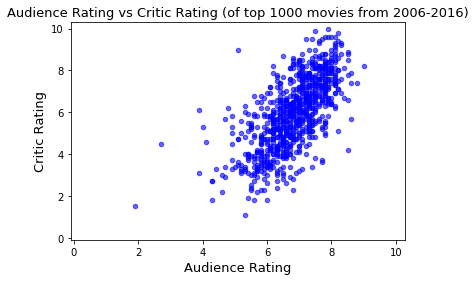

In [8]:
# Creating the scatterplot
fig = plt.figure()

ax = plt.axes()

audience = db_base['Rating']
critic = db_base['Metascore/10']

ax.scatter(audience, critic, c='blue', alpha=0.6, label='Ratings', s=20)

plt.title('Audience Rating vs Critic Rating (of top 1000 movies from 2006-2016)', fontsize=13)

plt.xlabel('Audience Rating', fontsize=13)
plt.ylabel('Critic Rating', fontsize=13)

plt.xlim([-0.1, 10.3])
plt.ylim([-0.1, 10.3])

Text(0, 0.5, 'Number of Movies with Difference')

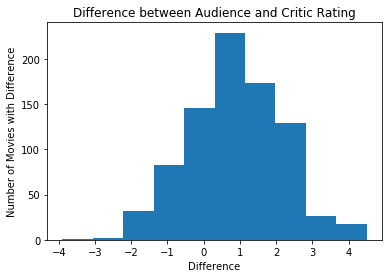

In [9]:
#Plot histogram of difference between audience rating and critic rating
difference = db_base['Difference']
plt.hist(difference)
plt.title('Difference between Audience and Critic Rating')
plt.xticks(ticks=[-4, -3, -2, -1, 0, 1, 2, 3, 4])
plt.xlabel('Difference')
plt.ylabel('Number of Movies with Difference')

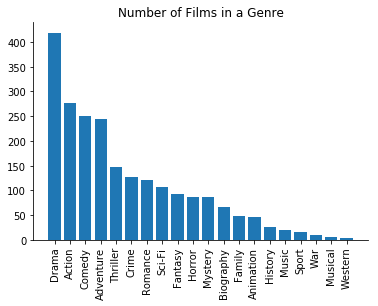

In [10]:
#Plot genreFreq as a bar chart
x = range(len(genreFreq))
x_label, y = zip(*genreFreq)

ax = plt.axes()

plt.bar(x, y, align='center',linewidth=0)
plt.xticks(x,x_label, rotation='vertical')
plt.title('Number of Films in a Genre')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.show()



In [11]:
def getGenreMovies(movies,genreList):
    movieTables = {}
    for genre in genreList:
        movieTables[genre] = movies.loc[movies['Genre'].str.contains(genre)]
    return movieTables

In [12]:
movieTb = getGenreMovies(db_movies,genreList)

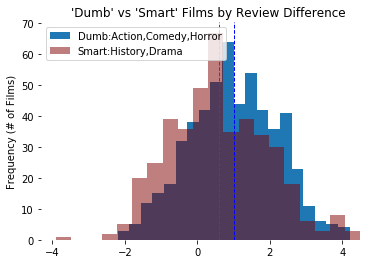

In [13]:
#Merge acion,comedy,and horror films
dumFilms = movieTb['Action'].combine_first(movieTb['Comedy'])
dumFilms = dumFilms.combine_first(movieTb['Horror'])

#Merge drama and historical films
branFilms = movieTb['Drama'].combine_first(movieTb['History'])

dumDiff = dumFilms['Difference']
branDiff = branFilms['Difference']

#plt.title('Difference in IMDb User Rating minus Metacritic Rating/10')
#plt.ylabel('Frequency')


#plt.show()
axes1 = dumDiff.hist(bins=20)
axes2 = branDiff.hist(bins=20,fc=(0.5,0,0,0.5))

axes1.set_title("'Dumb' vs 'Smart' Films by Review Difference")
axes1.legend(['Dumb:Action,Comedy,Horror','Smart:History,Drama'])
axes1.set_ylabel("Frequency (# of Films)")

axes1.grid(False)
axes1.set_frame_on(False)

plt.axvline(dumDiff.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(branDiff.mean(), color='red', linestyle='dashed', linewidth=1)

C:\Users\7surf\Documents\Cogs108\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


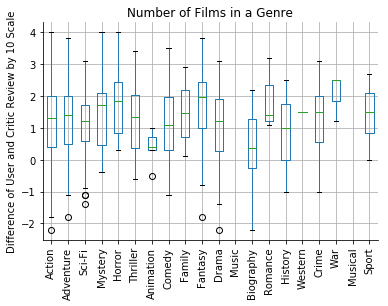

In [15]:
#Create a boxplot of all the distributions

#Get all the distributions in one place
filmDifferences = pd.DataFrame()

for genre,filmDiff in movieTb.items():
    filmDifferences[genre] = filmDiff['Difference']
    
filmDifferences.boxplot()


ax = plt.axes()

plt.xticks(rotation='vertical')
plt.title('Number of Films in a Genre')
ax.set_ylabel('Difference of User and Critic Review by 10 Scale')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.show()

In [16]:
#Get the mean and median
meanList = filmDifferences.mean()
medianList = filmDifferences.median()
print("[Means]")
print(meanList)
#Get highest mean
print('The highest mean difference:')
print (meanList.argmax(),end=": ")
print (meanList.max())
#Get lowest mean
print('The lowest mean difference:')
print (meanList.argmin(),end=": ")
print (meanList.min())
print()
print("[Medians]")
print(medianList)
#Get highest median
print('The highest median difference:')
print (medianList.argmax(),end=": ")
print (medianList.max())
#Get lowest median
print('The lowest median difference:')
print (medianList.argmin(),end=": ")
print (medianList.min())

[Means]
Action       1.246209
Adventure    1.259060
Sci-Fi       1.131884
Mystery      1.468750
Horror       1.800000
Thriller     1.258333
Animation    0.433333
Comedy       1.160465
Family       1.466667
Fantasy      1.581579
Drama        1.040625
Music             NaN
Biography    0.325000
Romance      1.828571
History      0.833333
Western      1.500000
Crime        1.303922
War          2.066667
Musical           NaN
Sport        1.425000
dtype: float64
The highest mean difference:
War: 2.0666666666666664
The lowest mean difference:
Biography: 0.3249999999999998

[Medians]
Action       1.30
Adventure    1.40
Sci-Fi       1.20
Mystery      1.70
Horror       1.85
Thriller     1.35
Animation    0.40
Comedy       1.10
Family       1.45
Fantasy      1.95
Drama        1.20
Music         NaN
Biography    0.35
Romance      1.40
History      1.00
Western      1.50
Crime        1.50
War          2.50
Musical       NaN
Sport        1.50
dtype: float64
The highest median difference:
War: 2.5


C:\Users\7surf\Documents\Cogs108\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  
C:\Users\7surf\Documents\Cogs108\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  if sys.path[0] == '':
C:\Users\7surf\Documents\Cogs108\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
C:\Users\7surf\Documents\Cogs108\lib\site-packages\ipykernel_launcher.py:23: FutureWar

## Data Analysis
Significance will be determined by ANOVA testing between the genre tables we created at an alpha of 0.05. In addition, in order to better understand how effective each genre is at determining the differences made, a separate table is created with all films. This table will have new binary variables which tell true/false if a movie contains a specific genre. These new variables will then be fit to a linear regression using least squares for estimating rating difference.

In addition, in order to test a certain prediction, there will be a student t-test with an alpha of 0.05 on two aggregate dataframes: one containing Action, Comedy, and Horror, and History and Drama for the other, to see if "dumb fun" and "smart" films have significantly different rating disparities, as well as a normality test of alpha=0.01 to see if their aggregate distributions are at least somewhat normal

Create new dataframes using the top five genres

In [17]:
#Get the correlation coefficients between ratings
genreCorr = list()
for genre in genreList:
    genreCorr.append((genre,movieTb[genre].corr()['Rating']['Metascore']))

In [18]:
[tup for tup in genreCorr if abs(tup[1]) > 0.5]

[('Action', 0.7261808519356865),
 ('Adventure', 0.7937970422660482),
 ('Sci-Fi', 0.7630651285364727),
 ('Mystery', 0.6428275934665594),
 ('Horror', 0.6414429601357307),
 ('Thriller', 0.6890793973415403),
 ('Animation', 0.8196422350911324),
 ('Comedy', 0.6929813404642322),
 ('Family', 0.7335523837834825),
 ('Fantasy', 0.6891858635667506),
 ('Drama', 0.5599125314814779),
 ('Music', 0.5064541608630745),
 ('Romance', 0.5938868533725077),
 ('History', 0.5359939486002501),
 ('Western', 0.9408736485209613),
 ('Crime', 0.6241714840770557),
 ('War', 0.5870188811669348),
 ('Musical', 0.6869385190597941),
 ('Sport', 0.6885776165669939)]

Perform a one-way ANOVA test on all genres

In [19]:
movieDifferences = list()
movieDifferences_genre = list()

#Get all genre differences
for movieTable in movieTb.items():
    movieDifferences.append(movieTable[1]["Difference"])
    movieDifferences_genre.append(movieTable[0])

assert(len(movieDifferences) == 20)    
    
#Perform the ANOVA test
f_val,p_val = stats.f_oneway(*movieDifferences)

#Print output
print("F Value:")
print(f_val)
print("P Value")
print(p_val)

F Value:
5.524034110041328
P Value
1.5920319548641825e-13


Codify genres from genreList to form predictions in db_movies

In [20]:
#Import linear regression models
import patsy
import statsmodels.api as sm

In [22]:
db_sample = db_base.copy()


#Isolate desired variables
db_sample = db_sample[['Title','Genre','Year',
                       'Runtime (Minutes)','Revenue (Millions)','Votes',
                       'Rating','Metascore',
                       'Metascore/10','Difference']]

#Create pd series for each genre and append to dataframe
for genre in genreList:
    db_sample[genre] = pd.Series([genre in row_sample['Genre'] for ind, row_sample in db_sample.iterrows()],db_sample.index)

#Convert column names for patsy design matrix
db_sample.rename(columns={'Sci-Fi':'Sci_Fi','Runtime (Minutes)':'Rt_Min','Revenue (Millions)':'Rev_Mil'},inplace=True)
    
db_sample.head()

,Title,Genre,Year,Rt_Min,Rev_Mil,Votes,Rating,Metascore,Metascore/10,Difference,...,Drama,Music,Biography,Romance,History,Western,Crime,War,Musical,Sport
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",2014,121,333.13,757074,8.1,76.0,7.6,0.5,...,False,False,False,False,False,False,False,False,False,False
1,Prometheus,"Adventure,Mystery,Sci-Fi",2012,124,126.46,485820,7.0,65.0,6.5,0.5,...,False,False,False,False,False,False,False,False,False,False
2,Split,"Horror,Thriller",2016,117,138.12,157606,7.3,62.0,6.2,1.1,...,False,False,False,False,False,False,False,False,False,False
3,Sing,"Animation,Comedy,Family",2016,108,270.32,60545,7.2,59.0,5.9,1.3,...,False,False,False,False,False,False,False,False,False,False
4,Suicide Squad,"Action,Adventure,Fantasy",2016,123,325.02,393727,6.2,40.0,4.0,2.2,...,False,False,False,False,False,False,False,False,False,False


In [23]:
outcome_1,predictors_1 = patsy.dmatrices('Difference ~ Action + Adventure + Sci_Fi + Mystery + Horror + Thriller + Animation + Comedy + Family + Fantasy + Drama + Music + Biography + Romance + History + Crime + Western + War + Musical + Sport',db_sample)
model_1 = sm.OLS(outcome_1,predictors_1)
result_1 = model_1.fit()

assert isinstance(outcome_1, patsy.design_info.DesignMatrix)
assert isinstance(predictors_1, patsy.design_info.DesignMatrix)
assert isinstance(model_1, sm.regression.linear_model.OLS)
assert isinstance(result_1, sm.regression.linear_model.RegressionResultsWrapper)


In [24]:
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     6.232
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           9.16e-16
Time:                        10:23:25   Log-Likelihood:                -1336.9
No. Observations:                 838   AIC:                             2716.
Df Residuals:                     817   BIC:                             2815.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8879      0.19

In [25]:
outcome_2,predictors_2 = patsy.dmatrices('Difference ~ Year + Votes + Rt_Min + Rev_Mil + Action + Adventure + Sci_Fi + Mystery + Horror + Thriller + Animation + Comedy + Family + Fantasy + Drama + Music + Biography + Romance + History + Crime + Western + War + Musical + Sport',db_sample)
model_2 = sm.OLS(outcome_2,predictors_2)
result_2 = model_2.fit()

assert isinstance(outcome_2, patsy.design_info.DesignMatrix)
assert isinstance(predictors_2, patsy.design_info.DesignMatrix)
assert isinstance(model_2, sm.regression.linear_model.OLS)
assert isinstance(result_2, sm.regression.linear_model.RegressionResultsWrapper)


In [26]:
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     6.215
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           3.92e-18
Time:                        10:23:29   Log-Likelihood:                -1325.8
No. Observations:                 838   AIC:                             2702.
Df Residuals:                     813   BIC:                             2820.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            35.4078     29.07

In [27]:
#Determine if it is normal

st_dum,p_dum = stats.normaltest(dumDiff)
st_bran,p_bran = stats.normaltest(branDiff)

is_n_dum = bool(p_dum > 0.01)
is_n_bran = bool(p_bran > 0.01)

t_stats = stats.ttest_ind(dumDiff,branDiff)

print("Is dumb film distribution normal?")
print(is_n_dum)
print("Is smart film distribution normal?")
print(is_n_bran)
print()

#Print the t-test on the chart
print(t_stats)
print()
print("The mean difference in 'dumb' films:")
print(dumDiff.mean())
print("The mean difference in 'smart' films:")
print(branDiff.mean())
print()
if t_stats[1] > 0.5 :
    print("There's no significant difference in rating disparity")
elif dumDiff.mean() >= branDiff.mean():
    print("'Dumb' films received greater user reviews")
else:
    print("'Smart' films received greater user reviews")

Is dumb film distribution normal?
True
Is smart film distribution normal?
True

Ttest_indResult(statistic=4.992334115500318, pvalue=7.077436715866359e-07)

The mean difference in 'dumb' films:
1.0016483516483528
The mean difference in 'smart' films:
0.5869047619047612

'Dumb' films received greater user reviews


## Ethics and Privacy
We do not foresee our analysis having any issues involving ethics and privacy. The datasets are provided by IMDb on their public website and their terms and conditions allow us to use the datasets for our project as long as we acknowledge that we got the data from them. Part  of their terms are to not scrape data from their website, which we were planning not to do regardless. All of the variables we will use in our analysis--movie title, critic score, audience score, genre--are publicly available on IMDb’s website. None of the information we will use is private or connected to any specific individuals, so we will not need to do any data anonymization.

How the kaggle database is curated is not readily transparent. The rank is not directly attached to any specific variable, and we are completely dependent on whomever curated the database that the films presented are as close to representing what the “top” 1000 movies are. More relevant to us is that we are comparing values from different sites, users from IMDb, and critics from Metacritic, which use different scales. Furthermore, the two sites may attract reviewers with varying mindsets within each group, and the users of each site are just a sample of people who review movies.


## Conclusions and Discussions

We did an ANOVA test instead of t-tests because we had multiple variables. Because the p-value was less than our alpha of .05, we can conclude that there is a statistically significant difference among the genre rating differences, such that War had the highest mean difference (2.067) and Biography had the lowest mean difference (0.325).

From our first least squares regression, because our f-statistic was less that .05, we conlcuded that the mean difference in rating is related to genre. We also learned that 13.2% of the variation in rating difference is due to genre. However, that does not necessarily mean that the variation in difference was caused by genre. Individually, Action, Animation, Drama, Romance, and Crime are the only genres with statistically significant mean differences between audience and critic rating. Action's mean difference was 1.246209. Animation's mean difference was 0.433333. Drama's mean difference was 1.040625. Romance's mean difference was 1.828571. Crime's mean difference was 1.303922.


Therefore, we were correct that Action and Drama would be rated significantly differently by audiences and critics, but we were wrong when we predicted that Horror, Historical, and Comedy would also have statistically significant differences in ratings. Also, the genres Animation, Romance, and Crime had statistically significant differences in rating, and these genres were not included in our predictions.

When Action, Horror, and Comedy were grouped together, as a combination of more "fun" genres, they had a larger difference between audience and critic rating than more "intellectual" movie genres like Drama and Historical, which we grouped together. Therefore, our prediction that audiences would rate fun movies higher was correct. However, we also predicted that critics would rate the intellectual genres higher than audiences would, and this was not what we found. The mean difference for the intellectual genre grouping was a positive number (.587), which means that, on average, audiences still rated intellectual movies higher than critics did. In fact, based on the medians of our boxplot and the list of genre means, audiences, on average, rated movies higher than critics did regardless of genre.

The difference between scoring becomes important when audiences start to see a failing in the critic’s role in helping audiences decide which movies to see. If audiences and critics do not agree in specific genres, then it is not valuable for audiences to look at critic reviews. Since audiences, on average, rated movies higher than critics did, across the board, audiences should be aware of this when checking a movie's rating to decide if they want to see the movie. If audiences do not see a movie because of critic ratings, they could be missing out on a movie they would really like, and also movie companies could potentially lose money. For an organization that houses critics, or for a critic him or herself, the failure to match the opinions of the wider population could see their careers earning less respect, and perhaps less money.

Since our findings show that audiences rate fun movies (Action, Horror, Comedy), Animation movies, Drama movies, Romance movies, and Crime movies significantly higher than than critics do, audiences should modify their interpretations of critic reviews. For those genres, users should add rouhgly 1 point or so onto the critic's rating, and then decide whether they think the movie is worth seeing with that score. For critics, these genre differences should open up paths for inquiry and introspection on why the difference exists and, if they want their reviews to be more helpful to audiences, how they can change their own review process and perspective to be more aligned with the general public's opionins.

This leads us into the limitations of our analysis. We are only looking at genre, and we are ignoring other variables which could affect the quality and reception of the film, including review votes, runtime, budget, and director, among others. Certain genres may attract certain values of these variables, and having ignored them, we leave the questions of “Is that the case?” or “Do these variables hold any value?” up in the air. We are also only looking at the top 1000 movies as decided by the dataset’s curator. The remaining films might behave differently in review disparities than the top 1000, and produce different correlations.

Ideas for future studies could examine the interplay between variables such as genre, budget, and revenue. It could also be interesting to look at some of the worst rated movies, by audiences and critics, instead of the top rated ones, and see which genres those movies tend to be from.

Overall, our hypothesis that genre would impact the difference between audience and critic ratings was correct, but only with regards to specific genres and specific groupings of genres. Furthermore, we were wrong when we predicted that critics would rate movies in a grouping of more serious genres higher than audiences would, but instead we found that audiences rate movies higher than critics do, in general, regardless of genre. Therefore, if audiences choose to consider critic ratings when deciding whether to see a movie or not, they should take into account that they would most likely rate the movie higher than the critic would.

Work breakdown: Mia and Chris came up with the idea. Robert did the data cleaning, pre-processing, and analysis. Mia did the scatterplot, the histogram, and a majority of the writing.